In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.cm as cm


def readifrit(path, nvar=0, moden=2, skipmoden=2):
    import struct
    import numpy as np
    openfile=open(path, "rb")
    dump = np.fromfile(openfile, dtype='i', count=moden)
    N1,N2,N3=np.fromfile(openfile, dtype='i', count=3)
#     print(N1,N2,N3)
    dump = np.fromfile(openfile, dtype='i', count=moden)
    data = np.zeros([N1, N2, N3])
    j = 0
    for i in range(nvar):
        openfile.seek(4*skipmoden, 1)
        for j in range(4):
            openfile.seek(N1*N2*N3, 1)
        openfile.seek(4*moden, 1)
    openfile.seek(4*skipmoden, 1)
    data[:, :, :] = np.reshape(np.fromfile(openfile, dtype='f4', count=N1 * N2 * N3), [N1, N2, N3])
    openfile.close()
    return N1,N2,N3,data


def downsample(data,f=2):
    data_new=(data[::2, ::2, ::2]+data[1::2, ::2, ::2]+
              data[::2, 1::2, ::2]+data[::2, ::2, 1::2]+
              data[1::2, 1::2, ::2]+data[::2, 1::2, 1::2]+
              data[1::2, ::2, 1::2]+data[1::2, 1::2, 1::2])
    return data_new

def pk(data, box_size, k_list_phys, mode=0, usefftw=False):
    N = data.shape[0]
    k_list = k_list_phys*box_size/N
    data=np.fft.rfftn(data)
    kx, ky, kz = np.mgrid[:N, :N, :(N/2+1)]
    kx[kx > N/2-1] = kx[kx > N/2-1]-N
    ky[ky > N/2-1] = ky[ky > N/2-1]-N
    kz[kz > N/2-1] = kz[kz > N/2-1]-N
    k=2.0*np.pi*np.sqrt(kx**2+ky**2+kz**2)/N
    if mode == 1:
        kf = 2.0*np.pi/N
        res = np.zeros(len(k_list)-1)
        for i in range(len(k_list)-1):
            if np.sum((k >= k_list[i]) & (k < k_list[i+1]))>0:
                res[i] = np.mean(np.abs(data[(k >= k_list[i]) & (k < k_list[i+1])])**2)
        return res*box_size**3 / N**6
    if mode==0:
        kf=2.0*np.pi/N
        h1, dump = np.histogram(k.flat,weights=np.abs(data.flat)**2,bins=k_list)
        h2, dump = np.histogram(k.flat,bins=k_list)
        h2[h2==0] = 1.0
        res = h1/h2
        return res*box_size**3/N**6
    if mode==2:
        kf=2.0*np.pi/N
        res=np.zeros(len(k_list))
        for i in range(len(k_list)):
            res[i]=np.mean(np.abs(data[(k>=k_list[i]-kf) & (k<k_list[i]+kf)])**2)
        return res*box_size**3/N**6
    if mode==2:
        return k,data

def pk2(data, data2, box_size, k_list_phys, mode=0, usefftw=False):
    N = data.shape[0]
    k_list = k_list_phys*box_size/N
    data=np.fft.rfftn(data)
    data2=np.fft.rfftn(data2)
    kx, ky, kz = np.mgrid[:N, :N, :(N/2+1)]
    kx[kx > N/2-1] = kx[kx > N/2-1]-N
    ky[ky > N/2-1] = ky[ky > N/2-1]-N
    kz[kz > N/2-1] = kz[kz > N/2-1]-N
    k=2.0*np.pi*np.sqrt(kx**2+ky**2+kz**2)/N
    if mode == 1:
        kf = 2.0*np.pi/N
        res = np.zeros(len(k_list)-1)
        for i in range(len(k_list)-1):
            if np.sum((k >= k_list[i]) & (k < k_list[i+1]))>0:
                res[i] = np.mean((data[(k >= k_list[i]) & (k < k_list[i+1])]
                                      * np.conjugate(data2[(k >= k_list[i]) & (k < k_list[i+1])])))
        return res*box_size**3 / N**6
    if mode==0:
        kf=2.0*np.pi/N
        h1, dump = np.histogram(k.flat,weights=np.real(data.flatten()*np.conjugate(data2.flatten())),bins=k_list)
        h2, dump = np.histogram(k.flat,bins=k_list)
        h2[h2==0] = 1.0
        res = h1/h2
        return res*box_size**3/N**6
    if mode==2:
        kf=2.0*np.pi/N
        res=np.zeros(len(k_list))
        for i in range(len(k_list)):
            res[i]=np.mean(np.abs(data[(k>=k_list[i]-kf) & (k<k_list[i]+kf)])**2)
        return res*box_size**3/N**6
    if mode==3:
        kf = 2.0*np.pi/N
        res = np.zeros(len(k_list)-1)
        res2 = np.zeros(len(k_list)-1)
        for i in range(len(k_list)-1):
            if np.sum((k >= k_list[i]) & (k < k_list[i+1]))>0:
#                 print(np.corrcoef(x=data[(k >= k_list[i]) & (k < k_list[i+1])].flatten(),
#                                       y=data2[(k >= k_list[i]) & (k < k_list[i+1])].flatten())[0][1])
                res[i] = (np.corrcoef(x=data[(k >= k_list[i]) & (k < k_list[i+1])].flatten(),
                                      y=data2[(k >= k_list[i]) & (k < k_list[i+1])].flatten())[0][1])
                res2[i] = np.mean(data[(k >= k_list[i]) & (k < k_list[i+1])].flatten() * 
                                  np.conjugate(data2[(k >= k_list[i]) & (k < k_list[i+1])].flatten()))
        return res, res2

#####

machine = 'ias'
%matplotlib inline

i_list=[0,1,2,3,4,5,6,7]

/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/home/kaurov/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-N

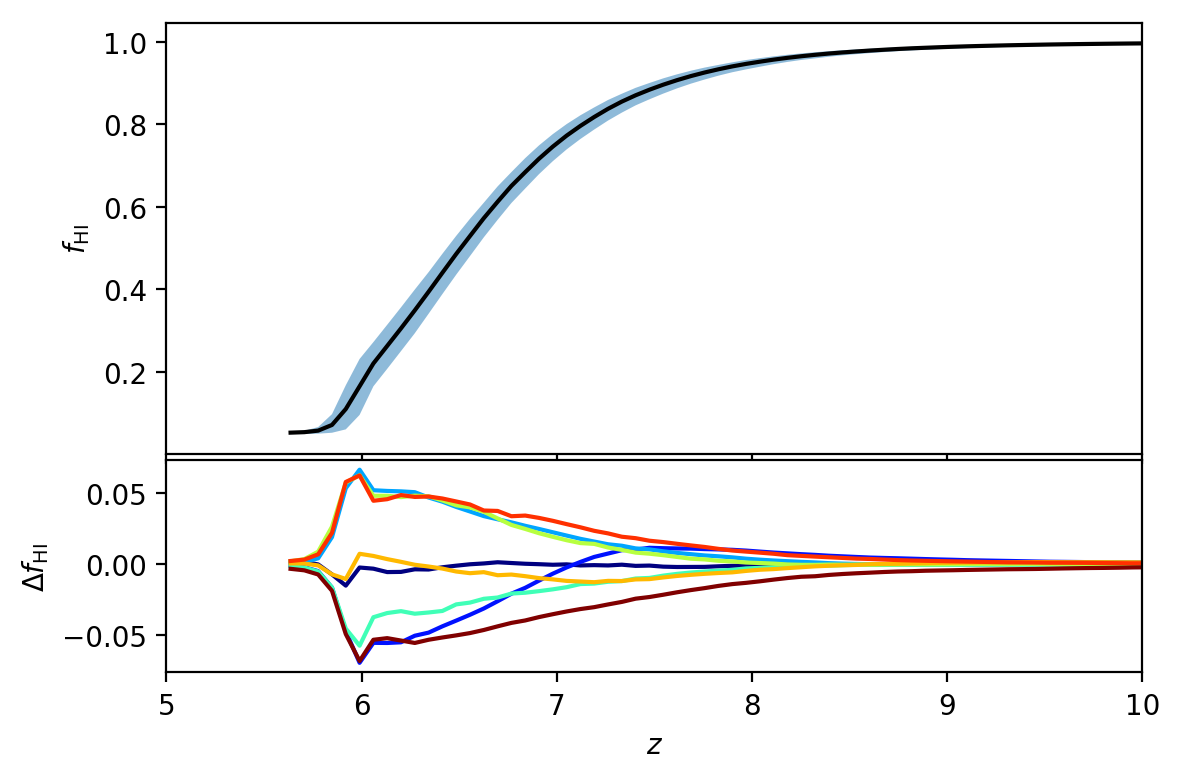

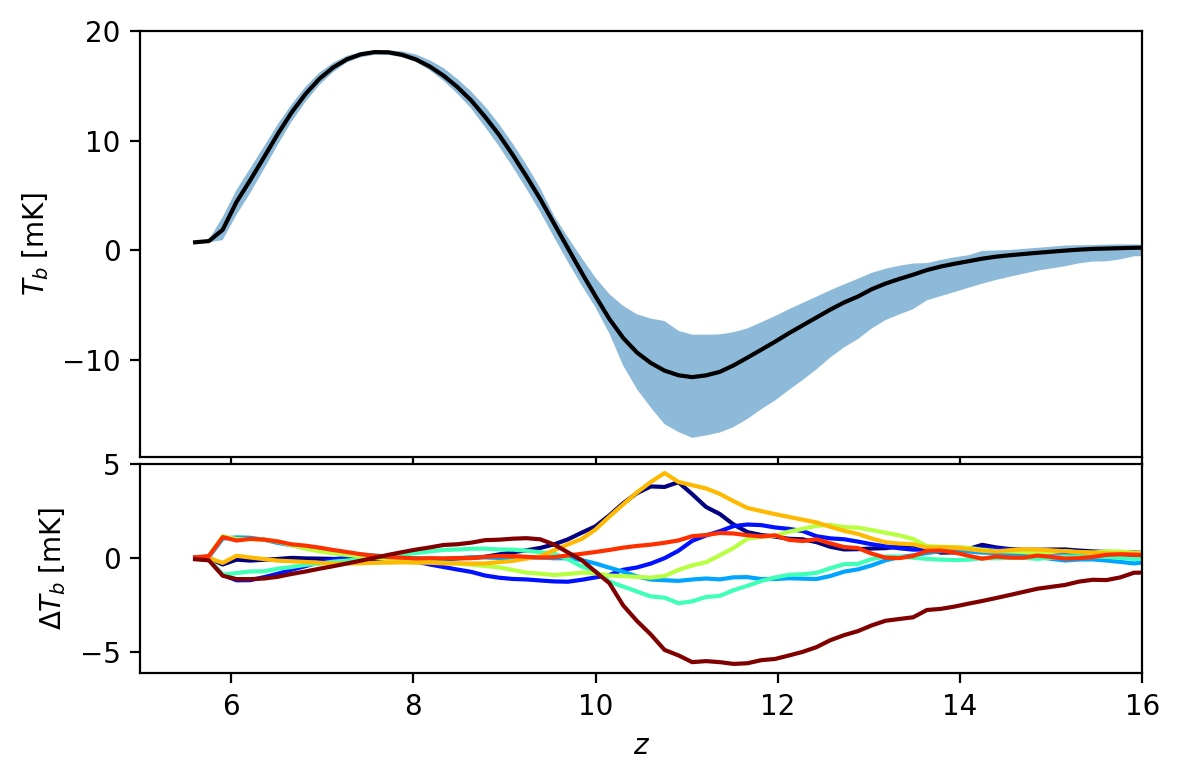

In [6]:
mode=64

a = 0.1000
res_all = []
z_list = np.linspace(5,12,100)
for i in i_list:
#     print(i)
    temp = []
    # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(4,i))
    if machine=='ias':
        files = glob.glob('/home/kaurov/scratch/rei/shuffle10/xLOG_xshuffle_%04i_%04i/rei.log'%(mode,i))
    if machine == 'prs':
        files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xLOG_xshuffle_%04i_%04i/rei.log'%(mode,i))
    if len(files)>0:
        d = np.genfromtxt(files[0])
        temp = np.interp(z_list, 1./d[::-1,0]-1., d[::-1,8], left=np.nan)
        res_all.append(temp)

res_all = np.array(res_all)

res_mean = np.nanmean(res_all, 0)

plt.figure(1, dpi=200)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.fill_between(z_list, np.nanmin(res_all, 0), np.nanmax(res_all, 0), alpha=0.5)
plt.plot(z_list, res_mean, 'k')
plt.ylabel(r'$f_\mathrm{HI}$')
plt.xlim([5,10])
plt.setp(ax1.get_xticklabels() , visible=False)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)


for i, val in enumerate(cm.jet(np.linspace(0,1,res_all.shape[0]))):
        plt.plot(z_list, res_all[i,:] - res_mean, color=val)

plt.xlim([5,10])
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\Delta} f_\mathrm{HI}$')
plt.tight_layout()
plt.subplots_adjust(hspace=0.03)

plt.savefig('pics/hist_ion_%i.png'%(mode))

import glob

a = 0.1000
res_all = []
z_list = np.linspace(5,20,100)
for i in i_list:
#     print(i)
    temp = []
    # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(2,i))
    if machine=='ias':
        files = glob.glob('/home/kaurov/scratch/rei/shuffle10/xLOG_xshuffle_%04i_%04i/rei.log'%(mode,i))
    if machine=='prs':
        files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xLOG_xshuffle_%04i_%04i/rei.log'%(mode,i))
    if len(files)>0:
        d = np.genfromtxt(files[0])
        temp = np.interp(z_list, 1./d[::-1,0]-1., d[::-1,25], left=np.nan)
        res_all.append(temp)

res_all = np.array(res_all)*1000

res_mean = np.nanmean(res_all, 0)

plt.figure(2, dpi=200)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.fill_between(z_list, np.nanmin(res_all, 0), np.nanmax(res_all, 0), alpha=0.5)
plt.plot(z_list, res_mean, 'k')
plt.ylabel(r'$T_b\;\mathrm{[mK]}$')
plt.xlim([5,16])
# plt.yscale('log')
plt.setp(ax1.get_xticklabels() , visible=False)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

from matplotlib import cm

for i, val in enumerate(cm.jet(np.linspace(0,1,res_all.shape[0]))):
#     if i in [0,6,7]:
        plt.plot(z_list, res_all[i,:] - res_mean, color=val)

plt.xlim([5,16])
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\Delta} T_b\;\mathrm{[mK]}$')
plt.tight_layout()
plt.subplots_adjust(hspace=0.03)

plt.savefig('pics/hist_21cm_%i.png'%(mode))


7.33 0.12004801920768307
0
1
2
3
4
5
6
7
7.33 0.12004801920768307
0
1
2
3
no data
4
5
6
7
no data
7.33 0.12004801920768307
0
1
2
3
4
5
6
7
7.33 0.12004801920768307
0


KeyboardInterrupt: 

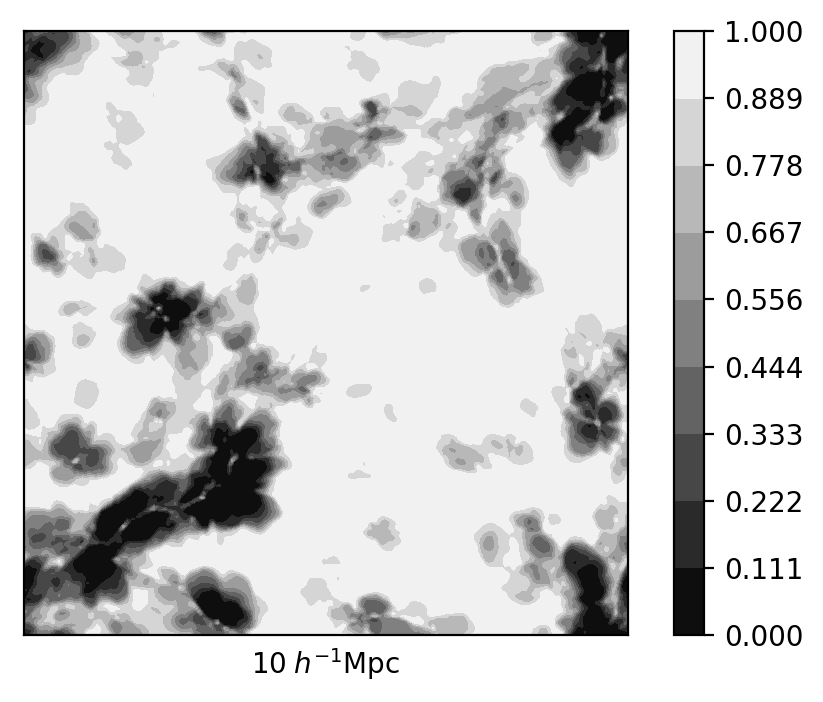

In [4]:
for mode in [2,4,8,16,32,64,128,256]:
    z = 7.33
    a = 1./(1.+z)
    print(z,a)
    res_all = []
    for i in i_list:
        print(i)
        temp = []
        # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(2,i))
        if machine=='ias':
            files = glob.glob('/home/kaurov/scratch/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
        if machine=='prs':
            files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
        files.sort()
    #     print(files)
        snaps_n = np.array([np.float(files[i][-10:-4]) for i in range(len(files))])
        # print(snaps_n[-1])
        # a_list = np.zeros(len(snaps))
        xn = np.where(snaps_n>=a)[0]
        if len(xn)>0:
            xn = xn[0]
            d1 = readifrit(files[xn])
            d2 = readifrit(files[xn-1])
            r = (snaps_n[xn]-a) / (snaps_n[xn] - snaps_n[xn-1])
            res = d1[3]*(1.-r) + r*d2[3]
            res_all.append(res)
        else:
            print('no data')


    plt.figure(3, dpi=200)
    plt.clf()
    N = len(res_all)
    plt.contourf(np.array(res_all).sum(0)[:, :, 0]/N, levels=np.linspace(0, 1, N+2), cmap='gray')#, norm=LogNorm())
    plt.gca().xaxis.set_ticks([])
    plt.gca().yaxis.set_ticks([])
    # plt.axis('equal')

    plt.gca().set_aspect('equal')
    plt.gca().autoscale(tight=True)

    # plt.gca().yaxis.set_visible(False)

    plt.xlabel(r'$10\;h^{-1}\mathrm{Mpc}$')

    plt.colorbar()

    plt.savefig('pics/slice_%i_%1.2f.png'%(mode,z))

In [ ]:
from IPython.display import Image
for mode in [8,16,32,64,128,256]:
    print('## %i'%(mode))
    print('![%i](pics/slice_%i_%1.2f.png)'%(mode,mode,z))

# 8
![8](pics/slice_8_7.00.png)
# 16
![16](pics/slice_16_7.00.png)
# 32
![32](pics/slice_32_7.00.png)
# 64
![64](pics/slice_64_7.00.png)
# 128
![128](pics/slice_128_7.00.png)
# 256
![256](pics/slice_256_7.00.png)

10.0 0.09090909090909091
0
['/home/kaurov/data/work/gic/shuffle_0002_0000/shuffle_mr2_M.d.bin']
1
['/home/kaurov/data/work/gic/shuffle_0002_0001/shuffle_mr2_M.d.bin']
2
['/home/kaurov/data/work/gic/shuffle_0002_0002/shuffle_mr2_M.d.bin']
3
['/home/kaurov/data/work/gic/shuffle_0002_0003/shuffle_mr2_M.d.bin']
4
['/home/kaurov/data/work/gic/shuffle_0002_0004/shuffle_mr2_M.d.bin']
5
['/home/kaurov/data/work/gic/shuffle_0002_0005/shuffle_mr2_M.d.bin']
6
['/home/kaurov/data/work/gic/shuffle_0002_0006/shuffle_mr2_M.d.bin']
7
['/home/kaurov/data/work/gic/shuffle_0002_0007/shuffle_mr2_M.d.bin']


/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


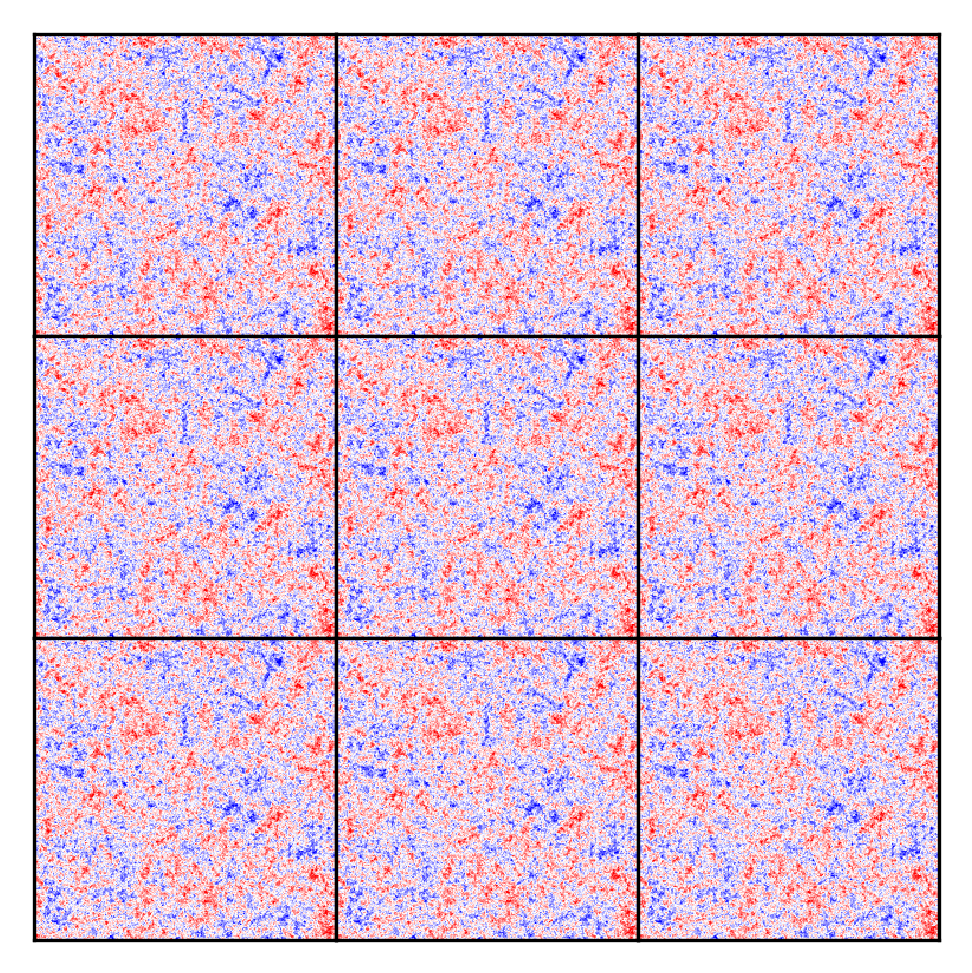

In [8]:
from mpl_toolkits.axes_grid1 import AxesGrid
i_list=range(8)
for mode in [2]:#8,16,32,64,128,256]:
    z = 10.
    a = 1./(1.+z)
    print(z,a)
    res_all = []
    
    files = glob.glob('/home/kaurov/data/work/gic/shuffle_%04i_%04i/*.bin'%(0,0))
    d1 = readifrit(files[0], moden=1, skipmoden=1)[3]
    res_all.append(d1)
    
    for i in i_list:
        print(i)
        temp = []
        # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(2,i))
        if machine=='ias':
            files = glob.glob('/home/kaurov/data/work/gic/shuffle_%04i_%04i/*.bin'%(mode,i))
        if machine=='prs':
            files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
        files.sort()
        print(files)
    #     print(files)
        d1 = readifrit(files[0], moden=1, skipmoden=1)[3]
        res_all.append(d1)
    
    fig = plt.figure(12, dpi=300)
    grid = AxesGrid(fig, 111,  # similar to subplot(142)
                        nrows_ncols=(3, 3),
                        axes_pad=0.0,
                        share_all=True,
                        label_mode="1"
                        )

    for i in range(9):
        im = grid[i].imshow(res_all[i][:,:,0], extent=[0,10,0,10], vmin=-0.33, vmax=0.33, cmap='bwr', interpolation="nearest")
    #plt.colorbar(im, cax = grid.cbar_axes[0])
    # grid.cbar_axes[0].colorbar(im)

    for cax in grid.cbar_axes:
        cax.toggle_label(False)

    # This affects all axes as share_all = True.
    grid.axes_llc.set_xticks([])#0, 2, 4, 6, 8,])
    grid.axes_llc.set_yticks([])#0, 2, 4, 6, 8,])

    plt.savefig('pics/ic_%04i.png'%mode,bbox_inches='tight')
    plt.savefig('pics/ic_%04i.pdf'%mode,bbox_inches='tight')
    # plt.figure(12,dpi=300)
    # plt.subplot(221)
    # plt.imshow((res_all[0][:,:,0]))
    # plt.subplot(222)
    # plt.imshow((res_all[1][:,:,0]))
    # plt.subplot(223)
    # plt.imshow((res_all[2][:,:,0]))
    # plt.subplot(224)
    # plt.imshow((res_all[3][:,:,0]))
    box_size=10
    k_list_phys=np.logspace(np.log10(2.*np.pi/10.-0.0001), np.log10(2.*np.pi/10.*256*np.sqrt(2)+0.0001), 32)
    k_list_phys_p = np.sqrt(k_list_phys[1:]*k_list_phys[:-1])
    a0 = []
    a00 = []
    for i in range(len(res_all)-1):
        a0.append(pk2(res_all[0], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))
        a00.append(pk2(res_all[i+1], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))
    
    np.savez('pics/ic_%04i_ps.npz'%mode, k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)

In [41]:
from multiprocessing import Pool
def f(temp):
    z, mmode, nvar = temp
    a = 1./(1.+z)
    print(z,a)
    res_all = []

    for i, mode in [[0,0], [0, mmode], [1, mmode], [2, mmode], [3, mmode],
                           [4, mmode], [5, mmode], [6, mmode], [7, mmode]]:
#         print(i)
        temp = []
        # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(2,i))
        if machine=='ias':
            files = glob.glob('/home/kaurov/scratch/rei/shuffle10/*OUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
        if machine=='prs':
            files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
    #    files.sort()
    #     print(files)
        snaps_n = np.array([np.float(files[i][-10:-4]) for i in range(len(files))])
#         print(snaps_n)
        temp = np.argsort(snaps_n)
        files = np.array(files)[temp]
        snaps_n = snaps_n[temp]
#         print(snaps_n[0])
        # a_list = np.zeros(len(snaps))
        xn = np.where(snaps_n>=a)[0]
        if len(xn)>0:
            xn = xn[0]
            if xn > 0:
                if (snaps_n[xn] >= a) & (snaps_n[xn-1] < a):
                    d1 = readifrit(files[xn], nvar=nvar)
                    d2 = readifrit(files[xn-1], nvar=nvar)
                    r = (snaps_n[xn]-a) / (snaps_n[xn] - snaps_n[xn-1])
                    res = d1[3]*(1.-r) + r*d2[3]
                    res_all.append(res)
        else:
            abc=0
#             print('no data')
    if len(res_all)>1:
        box_size=10
        k_list_phys=np.logspace(np.log10(2.*np.pi/10.-0.0001), np.log10(2.*np.pi/10.*256*np.sqrt(2)+0.0001), 32)
        k_list_phys_p = np.sqrt(k_list_phys[1:]*k_list_phys[:-1])
        a0 = []
        a00 = []
        for i in range(len(res_all)-1):
            a0.append(pk2(res_all[0], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))
            a00.append(pk2(res_all[i+1], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))

        if nvar==4:
            np.savez('pics/21cm_%1.2f_%04i_ps.npz'%(z, mmode), k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)
        if nvar==0:
            np.savez('pics/fion_%1.2f_%04i_ps.npz'%(z, mmode), k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)
        if nvar==1:
            np.savez('pics/dens_%1.2f_%04i_ps.npz'%(z, mmode), k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)  
        if nvar==2:
            np.savez('pics/temp_%1.2f_%04i_ps.npz'%(z, mmode), k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)    
    return 0

with Pool(16) as p:
    temp = []
    z_list = [ 8]
#     z_list = [14.0]
    z_list = [10.0]
    for z in z_list:#[7.33,7.67,8.0,9.0,10.0, 11.]:# [12., 13., 14., 15.0]:
        for mmode in [8,16,32,64,128]:
            for nvar in [4]:
                temp.append([z, mmode, nvar])
    print(p.map(f, temp))

10.0 0.09090909090909091
10.0 0.09090909090909091
10.0 0.09090909090909091
10.0 0.09090909090909091
10.0 0.09090909090909091


/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: Comp

[0, 0, 0, 0, 0]


In [30]:
# for z in [7.33,7.67,8.0,9.0,10.0, 11., 12., 13., 14., 15.0]:
#     for mmode in [2,4,8,16,32,64,128,256]:
#         a = 1./(1.+z)
#         print(z,a)
#         res_all = []
        
#         for i, mode in [[0,0], [0, mmode], [1, mmode], [2, mmode], [3, mmode],
#                                [4, mmode], [5, mmode], [6, mmode], [7, mmode]]:
#             print(i)
#             temp = []
#             # files = glob.glob('/scratch/kaurov/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(2,i))
#             if machine=='ias':
#                 files = glob.glob('/home/kaurov/scratch/rei/shuffle10/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
#             if machine=='prs':
#                 files = glob.glob('/home/alex.kaurov/scratch/shuffle/jobs/xOUT_xshuffle_%04i_%04i/*.bin'%(mode,i))
#             files.sort()
#         #     print(files)
#             snaps_n = np.array([np.float(files[i][-10:-4]) for i in range(len(files))])
#             # print(snaps_n[-1])
#             # a_list = np.zeros(len(snaps))
#             xn = np.where(snaps_n>=a)[0]
#             if len(xn)>0:
#                 xn = xn[0]
#                 d1 = readifrit(files[xn], nvar=4)
#                 d2 = readifrit(files[xn-1], nvar=4)
#                 r = (snaps_n[xn]-a) / (snaps_n[xn] - snaps_n[xn-1])
#                 res = d1[3]*(1.-r) + r*d2[3]
#                 res_all.append(res)
#             else:
#                 print('no data')
        
#         box_size=10
#         k_list_phys=np.logspace(np.log10(2.*np.pi/10.-0.0001), np.log10(2.*np.pi/10.*256*np.sqrt(2)+0.0001), 32)
#         k_list_phys_p = np.sqrt(k_list_phys[1:]*k_list_phys[:-1])
#         a0 = []
#         a00 = []
#         for i in range(len(res_all)-1):
#             a0.append(pk2(res_all[0], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))
#             a00.append(pk2(res_all[i+1], res_all[i+1], box_size=box_size, k_list_phys=k_list_phys, mode=3))
        
#         np.savez('pics/21cm_%1.2f_%04i_ps.npz'%(z, mmode), k_list_phys_p=k_list_phys_p, a0=a0, a00=a00)

7.33 0.12004801920768307
0
0
1
2
3
4
5
6
7


/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
/home/kaurov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


7.33 0.12004801920768307
0
0
1
2
3
no data
4
5
6
7
no data
7.33 0.12004801920768307
0
0
1
2
3
4
5
6
7
7.33 0.12004801920768307
0
0
1
2
no data
3
4
5
6
7
7.33 0.12004801920768307
0
0
1
2
3
4
5
6
7
7.33 0.12004801920768307
0
0
1
2
3
4
5
6
7
7.33 0.12004801920768307
0
0
1


KeyboardInterrupt: 

a  1
a  3
a  5
a  7
a  9
a  2.0
error
a  4.0
a  6.0
a  8.0
error
a  10.0
error


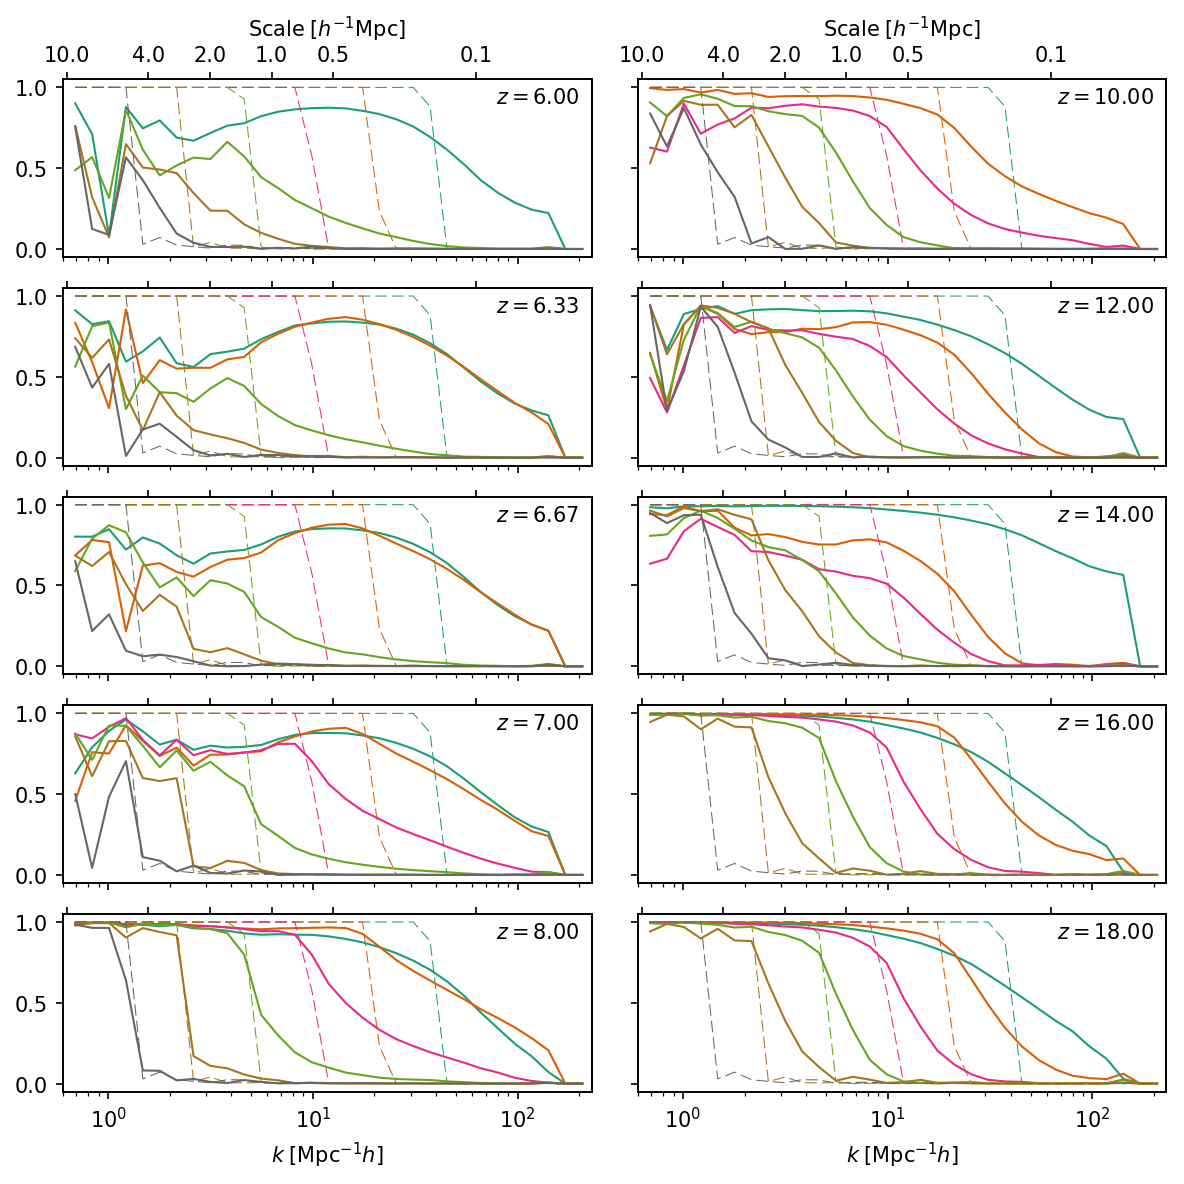

In [5]:
import matplotlib

fig = plt.figure(figsize=(8,8), dpi=150)
plt.clf()

z_list = [6.00, 6.33, 6.67, 7.00, 7.33, 7.67,8.00, 10., 11.00, 12.00, 13., 14.0]
z_list = [6.00, 6.33, 6.67, 7.00, 8.00, 10.,  12.00, 14.0,16.,18.]
mode_list = [4, 8,16,32,64,128]

# z_list = [8.00, 10., 11.00, 12.00, 13., 14.0]

# z_list = [6.00, 6.33, 6.67, 7.00]#, 7.33, 7.67, 8.00, 9.00, 10., 11.00, 12.00, 13., 14.0]:

for i_z in range(len(z_list)):
    z = z_list[i_z]
    
    cmap = matplotlib.cm.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0,1,len(mode_list))]

    if (i_z<len(z_list)/2):
        ax1 = fig.add_subplot(len(z_list)/2,2,i_z*2+1)
        print('a ',i_z*2+1)
    else:
        ax1 = fig.add_subplot(len(z_list)/2,2,int((i_z-len(z_list)/2)*2+2))
        print('a ',(i_z-len(z_list)/2)*2+2)
    ax2 = ax1.twiny()


    for i in range(len(mode_list)):
        mode = mode_list[i]
        try:
            ic_data = np.load('pics/ic_%04i_ps.npz'%mode)
            filt = np.array(ic_data['a0'][:,0,:]).mean(0) > -1
            a0 = np.array(ic_data['a0'])
            ax1.plot(ic_data['k_list_phys_p'][filt], np.abs(np.array(a0[:,0,:]).mean(0)[filt]), 
                     '--', lw=0.5, color=colors[i])
#             z_data = np.load('pics/fion_%1.2f_%04i_ps.npz'%(z, mode))
#             z_data = np.load('pics/dens_%1.2f_%04i_ps.npz'%(z, mode))
            z_data = np.load('pics/21cm_%1.2f_%04i_ps.npz'%(z, mode))
            a0 = np.array(z_data['a0'])
            if np.sum(a0)>0:
                ax1.plot(z_data['k_list_phys_p'][filt], np.abs(np.array(a0[:,0,:]).mean(0)[filt]), 
                         '-', lw=1, color=colors[i])
        except:
            print('error')
    #     a0 = np.array(z_data['a0'])
    #     a00 = np.array(z_data['a00'])
    #     t = a0[0,0,:]/a00[0,0,:]
    #     ax1.plot(ic_data['k_list_phys_p'][filt], t, '--', lw=1, color=colors[i])

    ax1.set_xscale('log')
    ax1.set_xlim([0.6,230])
    ax2.set_xscale('log')

    def tick_function(X):
        V = 2.*np.pi/X
        return ["%.1f" % z for z in V]

    new_tick_locations = 2.*np.pi / np.array([0.1,0.5,1.0,2.0,4.0,10.])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    if (i_z==0) or (i_z==len(z_list)/2):
        ax2.set_xticklabels(tick_function(new_tick_locations))
        ax2.set_xlabel(r"$\mathrm{Scale}\;[h^{-1}\mathrm{Mpc}]$")
    else:
        ax2.set_xticklabels([''])
    
    if (i_z>=len(z_list)/2):
        ax1.set_yticklabels([''])
    
    if (i_z==len(z_list)/2-1) or (i_z==len(z_list)-1):
        ax1.set_xlabel(r"$k\;[\mathrm{Mpc}^{-1}h]$")
    else:
        ax1.set_xticklabels([''])
        
    ax2.tick_params(axis='x',which='minor',top='off')

    ax1.text(200, 1., '$z=%2.2f$'%z, horizontalalignment='right',
      verticalalignment='top')
    
#     plt.legend()
    #     plt.title(z)

plt.tight_layout()
plt.savefig('pics/rk_21cm_all_%1.2f.png'%(z), dpi=300)
plt.savefig('pics/rk_21cm_all.pdf')

error
error
error
error
error
error
error
error
error


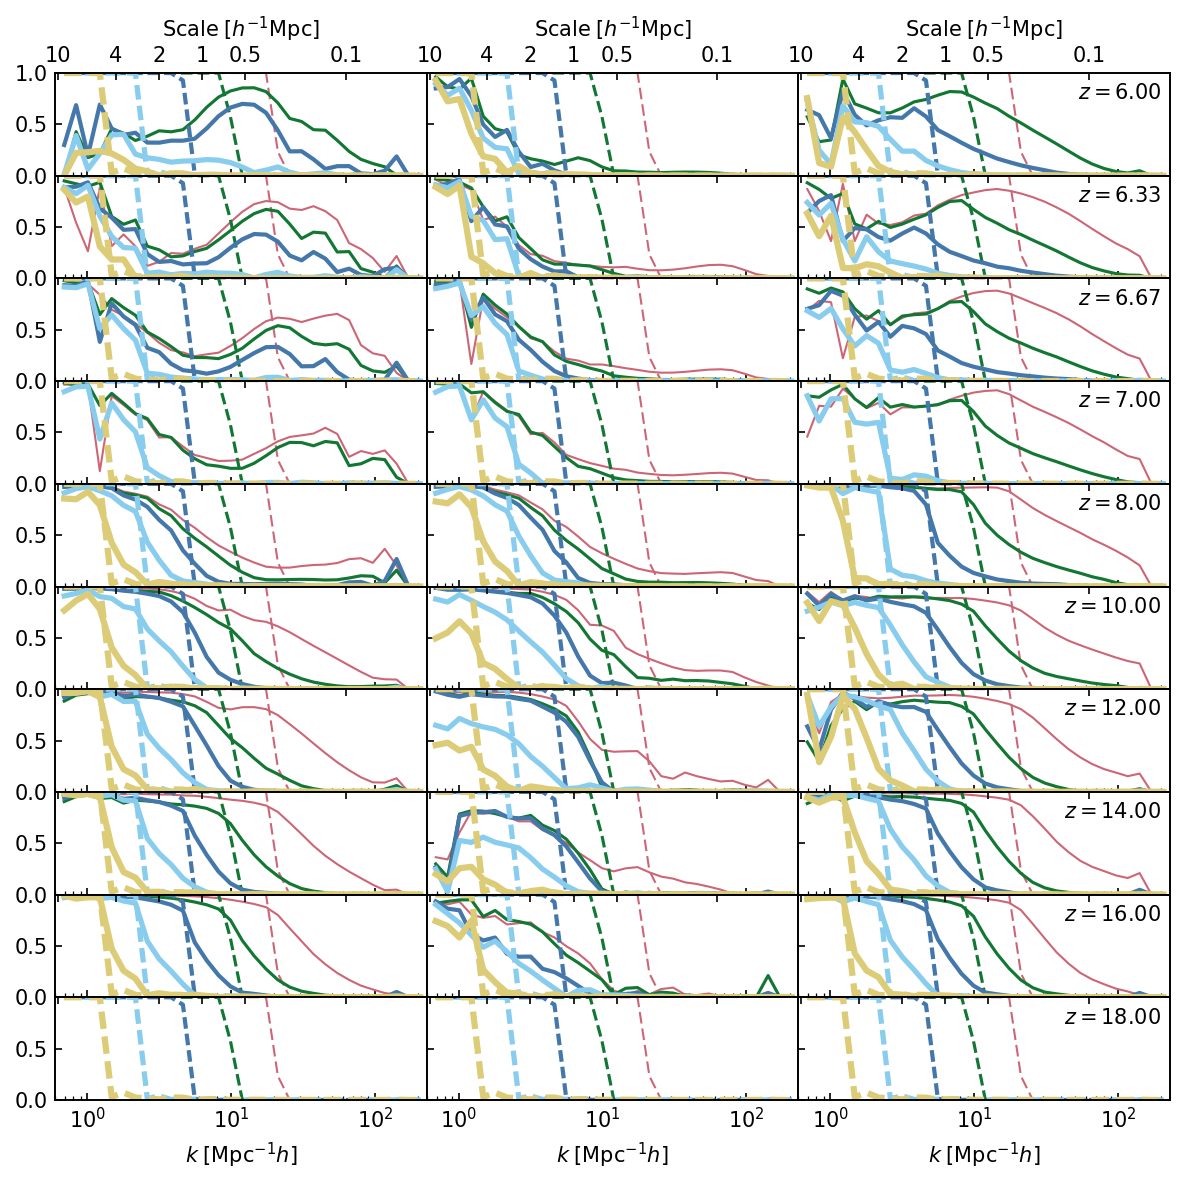

In [42]:
import matplotlib
import seaborn.apionly as sns
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

fig = plt.figure(figsize=(8,8), dpi=150)
plt.clf()

z_list = [6.00, 6.33, 6.67, 7.00, 7.33, 7.67,8.00, 10., 11.00, 12.00, 13., 14.0]
z_list = [6.00, 6.33, 6.67, 7.00, 8.00, 10.,  12.00, 14.0,16.,18.]
mode_list = [8, 16, 32, 64, 128]

# z_list = [8.00, 10., 11.00, 12.00, 13., 14.0]

# z_list = [6.00, 6.33, 6.67, 7.00]#, 7.33, 7.67, 8.00, 9.00, 10., 11.00, 12.00, 13., 14.0]:

for i_z in range(len(z_list)):
    z = z_list[i_z]
    
    cmap = matplotlib.cm.get_cmap('Set1')
    colors = [cmap(i) for i in np.linspace(0,1,len(mode_list))]
    colors = ('#CC6677','#117733','#4477AA','#88CCEE','#DDCC77','#AA4499')
    lws = (1.0,1.5,2.0,2.5,3)#2.5, 2.0, 1.5, 1.0)

    ax1 = fig.add_subplot(len(z_list),3,i_z*3+1)
    ax2 = ax1.twiny()

    ax11 = fig.add_subplot(len(z_list),3,i_z*3+2)
    ax21 = ax11.twiny()

    ax12 = fig.add_subplot(len(z_list),3,i_z*3+3)
    ax22 = ax12.twiny()


    for i in range(len(mode_list)):
        mode = mode_list[i]
        try:
            ic_data = np.load('pics/ic_%04i_ps.npz'%mode)
            filt = np.array(ic_data['a0'][:,0,:]).mean(0) > -1
            a0z = np.array(ic_data['a0'])
            ax1.plot(ic_data['k_list_phys_p'][filt], np.abs(np.array(a0z[:,0,:]).mean(0)[filt]), 
                     '--', lw=lws[i], color=colors[i])
            ax11.plot(ic_data['k_list_phys_p'][filt], np.abs(np.array(a0z[:,0,:]).mean(0)[filt]), 
                     '--', lw=lws[i], color=colors[i])
            ax12.plot(ic_data['k_list_phys_p'][filt], np.abs(np.array(a0z[:,0,:]).mean(0)[filt]), 
                     '--', lw=lws[i], color=colors[i])
            
            z_data = np.load('pics/temp_%1.2f_%04i_ps.npz'%(z, mode))
            a0 = np.array(z_data['a0'])
            if np.sum(a0)>0:
                ax1.plot(z_data['k_list_phys_p'][filt], np.abs(np.array(a0[:,0,:]).mean(0)[filt]), 
                         '-', lw=lws[i], color=colors[i])
            z_data = np.load('pics/fion_%1.2f_%04i_ps.npz'%(z, mode))
            a0 = np.array(z_data['a0'])
            if np.sum(a0)>0:
                ax11.plot(z_data['k_list_phys_p'][filt], np.abs(np.array(a0[:,0,:]).mean(0)[filt]), 
                         '-', lw=lws[i], color=colors[i])
            z_data = np.load('pics/21cm_%1.2f_%04i_ps.npz'%(z, mode))
            a0 = np.array(z_data['a0'])
            if np.sum(a0)>0:
                ax12.plot(z_data['k_list_phys_p'][filt], np.abs(np.array(a0[:,0,:]).mean(0)[filt]), 
                         '-', lw=lws[i], color=colors[i])
        except:
            print('error')
    #     a0 = np.array(z_data['a0'])
    #     a00 = np.array(z_data['a00'])
    #     t = a0[0,0,:]/a00[0,0,:]
    #     ax1.plot(ic_data['k_list_phys_p'][filt], t, '--', lw=1, color=colors[i])

    ax1.set_ylim([0,1])
    ax1.set_yticks([0,0.5])
    if i_z==0:
        ax1.set_yticks([0,0.5,1.0])
        
    ax11.set_ylim([0,1])
    ax12.set_ylim([0,1])
    
    ax1.set_xscale('log')
    ax1.set_xlim([0.6,230])
    ax2.set_xscale('log')

    ax11.set_xscale('log')
    ax11.set_xlim([0.6,230])
    ax21.set_xscale('log')

    ax12.set_xscale('log')
    ax12.set_xlim([0.6,230])
    ax22.set_xscale('log')

    def tick_function(X):
        V = 2.*np.pi/X
        temp = np.array(["%.1f" % z for z in V])
        temp[V>0.999] = np.array(["%i" % z for z in V[V>0.999]])
        return temp

    new_tick_locations = 2.*np.pi / np.array([0.1,0.5,1.0,2.0,4.0,10.])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax21.set_xlim(ax1.get_xlim())
    ax21.set_xticks(new_tick_locations)
    ax22.set_xlim(ax1.get_xlim())
    ax22.set_xticks(new_tick_locations)
    
    if (i_z==0):
        ax2.set_xticklabels(tick_function(new_tick_locations))
        ax2.set_xlabel(r"$\mathrm{Scale}\;[h^{-1}\mathrm{Mpc}]$")
        ax21.set_xticklabels(tick_function(new_tick_locations))
        ax21.set_xlabel(r"$\mathrm{Scale}\;[h^{-1}\mathrm{Mpc}]$")
        ax22.set_xticklabels(tick_function(new_tick_locations))
        ax22.set_xlabel(r"$\mathrm{Scale}\;[h^{-1}\mathrm{Mpc}]$")
    else:
        ax2.set_xticklabels([''])
        ax21.set_xticklabels([''])
        ax22.set_xticklabels([''])
    
    ax11.set_yticklabels([''])
    ax12.set_yticklabels([''])
    ax21.set_yticklabels([''])
    ax22.set_yticklabels([''])
    
    if (i_z==len(z_list)-1):
        ax1.set_xlabel(r"$k\;[\mathrm{Mpc}^{-1}h]$")
        ax11.set_xlabel(r"$k\;[\mathrm{Mpc}^{-1}h]$")
        ax12.set_xlabel(r"$k\;[\mathrm{Mpc}^{-1}h]$")
    else:
        ax1.set_xticklabels([''])
        ax11.set_xticklabels([''])
        ax12.set_xticklabels([''])
        
    ax2.tick_params(axis='x',which='minor',top='off')
    ax21.tick_params(axis='x',which='minor',top='off')
    ax22.tick_params(axis='x',which='minor',top='off')

    ax12.text(200, .9, '$z=%2.2f$'%z, horizontalalignment='right',
      verticalalignment='top')
    
#     plt.legend()
    #     plt.title(z)

plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
# plt.savefig('pics/rk_21cm_all.png', dpi=300)
plt.savefig('pics/rk_21cm_all.eps')

# a0